<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span><ul class="toc-item"><li><span><a href="#DBS-with-Virtual-Permitivity" data-toc-modified-id="DBS-with-Virtual-Permitivity-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>DBS with Virtual Permitivity</a></span></li><li><span><a href="#Enriched-FEM:-No-Virtual-Permitivity" data-toc-modified-id="Enriched-FEM:-No-Virtual-Permitivity-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Enriched FEM: No Virtual Permitivity</a></span></li></ul></li><li><span><a href="#Monitors" data-toc-modified-id="Monitors-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Monitors</a></span><ul class="toc-item"><li><span><a href="#Total-integrals" data-toc-modified-id="Total-integrals-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Total integrals</a></span></li><li><span><a href="#Number-of-Degrees-of-Freedom" data-toc-modified-id="Number-of-Degrees-of-Freedom-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Number of Degrees of Freedom</a></span></li><li><span><a href="#Times" data-toc-modified-id="Times-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Times</a></span></li></ul></li></ul></div>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes,InsetPosition, mark_inset)
from matplotlib.offsetbox import AnchoredText

import numpy as np
from dolfin import *
from multiphenics import *

# Goal
We have seen before that the eFEM needs the imperical parameter of the surface impedance. This parameter is often overlooked. Here we investigate its effect on the value of the floating potential which is what LFP or EEG sensors record.

In [2]:
# some global parameters
tol = DOLFIN_EPS
degree = 2    # degree of Lagrange finite elements
sigma0 = 1    # tissue conductivity (unitless)
N = 4         # number of contacts on the electrode
f0 = 1e-15    # a zero forcing (optional - added for stability)

In [3]:
# Mesh selection
mesh_name = 'DBS'
path = './meshes/'+mesh_name+'/'
mesh = Mesh(path+mesh_name+".xml")
subdomains = MeshFunction("size_t", mesh, path+mesh_name+"_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, path+mesh_name+"_facet_region.xml")
cnt_id = 25 # this is the id of first contact in the mesh

## uncomment the following lines if you want to view in Paraview
# File(path+mesh_name+"_boundaries.pvd") << boundaries
# File(path+mesh_name+"_subdomains.pvd") << subdomains

## Boundary conditions
Of course we keep the BCs constant in all cases.

In [4]:
# function space def.
V = FunctionSpace(mesh, "Lagrange", degree)
R = FunctionSpace(mesh, "R", 0)       
W = BlockFunctionSpace([V]+[R]*N)   
dof_fem = V.dim()   # degrees of freedom on the domain
dof_efem = W.dim()  # degrees of freedom of the mixed space (=dof_fem+4)

x = SpatialCoordinate(mesh)
dx = Measure("dx")(subdomain_data=subdomains)
ds = Measure("ds")(subdomain_data=boundaries)
n = FacetNormal(mesh)

# we need the area of each contact on the weak form
areas = [assemble(2*pi*x[0]*dot(n,n)*ds(cnt_id+i)) for i in range(N)] 

sigma = sigma0 # conductivity constant 

# forcing
f= Constant(f0)


# We need to specify the type of input for the weak form
input_types = ['I' for i in range(N)]
inputs = [Constant(0) for i in range(N)] 

# fixed potential on C0 and C2
inputs[0] = Constant(-1e-9)

# the exterior boundary conditions are easy.
bc_bottom = DirichletBC(W.sub(0), Constant(0), boundaries, 3) # bottom

# this makes a block BCs object (note the emptyness of the contacts' block)
bcs = BlockDirichletBC([[ bc_bottom ]]+ 
                       [[], [], [], []])

In [5]:
zs = np.logspace(-4,4,9,endpoint=True) 
monitor_efem = dict(u = [],     # solution on domain
                   U0 = [],     # C0 floating potential
                   U1 = [],     # C1 floating potential
                   U2 = [],     # C2 floating potential
                   U3 = [],     # C3 floating potential
                   )
for z in zs:
    # WEAK FORM
    # define the mixed elements
    u_mix = BlockTrialFunction(W)
    v_mix = BlockTestFunction(W)

    # split the mixed elemetns
    u_spl = block_split(u_mix)
    v_spl = block_split(v_mix)

    # RHS
    a_00 = 2*pi*x[0]*inner(sigma*grad(u_spl[0]), grad(v_spl[0]))*dx
    a_0n = []
    a_n0 = []
    a_nn = []
    for i in range(N):
        a_00 += 2*pi*x[0]*dot(u_spl[0],v_spl[0])/z*ds(cnt_id+i)
        if input_types[i]=='I':
            a_0n.append(-2*pi*x[0]*dot(u_spl[0], v_spl[i+1])/z*ds(cnt_id+i))
            a_n0.append(-2*pi*x[0]*dot(u_spl[i+1], v_spl[0])/z*ds(cnt_id+i))
            a_nn.append(+2*pi*x[0]*dot(u_spl[i+1], v_spl[i+1])/z*ds(cnt_id+i))
        else:
            a_0n.append(0)
            a_n0.append(0)
            a_nn.append(0)

    a = np.zeros((N+1,N+1), dtype=type(a_00))
    np.fill_diagonal(a, [a_00]+ a_nn)
    a[0,1:] = a_n0
    a[1:,0] = a_0n
    a = a.tolist()

    # LHS
    b0 = [ 2*pi*x[0]*f*v_spl[0]*dx ] 
    bn = []
    for i in range(N):
        if input_types[i]=='I':
            bn.append(2*pi*x[0]*inputs[i]*v_spl[i+1]/areas[i]*ds(cnt_id+i))
        else:
            bn.append(2*pi*x[0]*inputs[i]*v_spl[0]/z*ds(cnt_id+i))
    b = b0 + bn

    A = block_assemble(a)
    B = block_assemble(b)
    bcs.apply(A)
    bcs.apply(B)
    U = BlockFunction(W)
    block_solve(A, U.block_vector(), B)
    
    monitor_efem['u'].append(U[0])
    monitor_efem['U0'].append(U[1].vector()[0])
    monitor_efem['U1'].append(U[2].vector()[0])
    monitor_efem['U2'].append(U[3].vector()[0])
    monitor_efem['U3'].append(U[4].vector()[0])

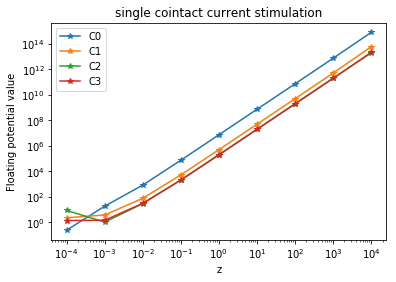

In [6]:
for i in range(4):
    plt.loglog(zs, [abs(fp) for fp in monitor_efem['U'+str(i)]],
               label='C'+str(i), marker='*')
    plt.legend()
plt.xlabel('z')
plt.ylabel('Floating potential value')
plt.title('single cointact current stimulation')
plt.savefig('results/FP_varations_singlecontact.png', dpi=300,
           bbox_inches='tight')

Note that $z<0.001$ corresponds a to such a small surface impendance that the system neglects the Poissonic term of the weak form. In that regime, the system is ill-conditioned, and any degeneracy due to mesh low quality may be amplified (as we can see in the first plot below). 

In well-posed range of $z>0.001$, however, one can see that for a single contact current controlled stimulation, all the floating potentials will increase by increment of surface impedance. That's expected. In fact, we know that this increase is linear as well (due to linearity of Poisson equaiton): Under a constant current constraint, with an impedance twice as strong, a voltage of twice as big will be induced on the system (including the floating potentials).

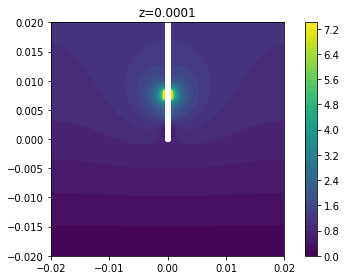

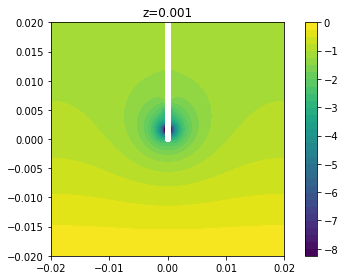

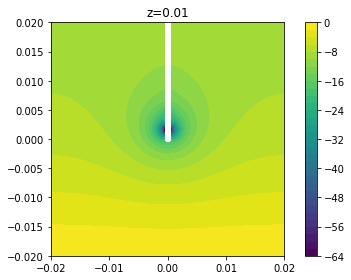

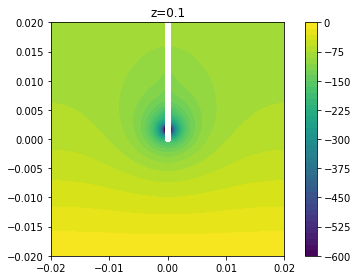

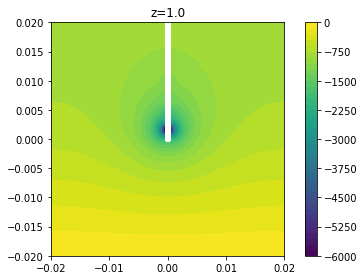

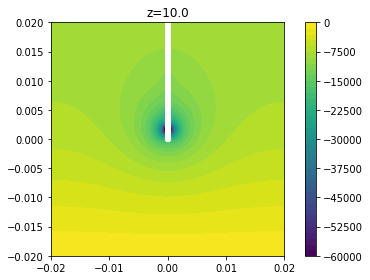

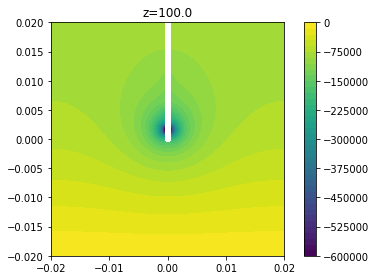

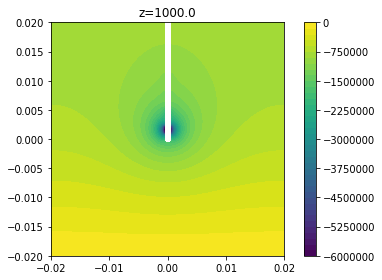

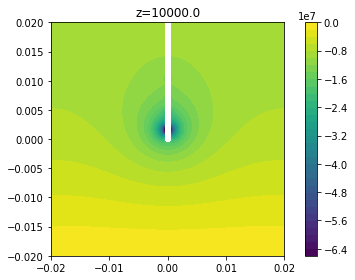

<Figure size 432x288 with 0 Axes>

In [7]:
for i, z in enumerate(zs):
    m = plot(monitor_efem['u'][i])
    plt.colorbar(m)
    plt.title('z='+str(z))
    plt.tight_layout()
    plt.show()
    plt.clf()

Note the unphysicial high voltage on C2 on the first plot (ill-coniditioned case). There's no stimulation there, however, the combination of the round-off errors and the imperfectness of our mesh deceived the solver. 

## A multi-contact stimulation
We expect the same linear variation. 

In [8]:
inputs[2] = Constant(+1e-9)

In [9]:
zs = np.logspace(-4,4,9,endpoint=True) 
monitor_efem = dict(u = [],     # solution on domain
                   U0 = [],     # C0 floating potential
                   U1 = [],     # C1 floating potential
                   U2 = [],     # C2 floating potential
                   U3 = [],     # C3 floating potential
                   )
for z in zs:
    # WEAK FORM
    # define the mixed elements
    u_mix = BlockTrialFunction(W)
    v_mix = BlockTestFunction(W)

    # split the mixed elemetns
    u_spl = block_split(u_mix)
    v_spl = block_split(v_mix)

    # RHS
    a_00 = 2*pi*x[0]*inner(sigma*grad(u_spl[0]), grad(v_spl[0]))*dx
    a_0n = []
    a_n0 = []
    a_nn = []
    for i in range(N):
        a_00 += 2*pi*x[0]*dot(u_spl[0],v_spl[0])/z*ds(cnt_id+i)
        if input_types[i]=='I':
            a_0n.append(-2*pi*x[0]*dot(u_spl[0], v_spl[i+1])/z*ds(cnt_id+i))
            a_n0.append(-2*pi*x[0]*dot(u_spl[i+1], v_spl[0])/z*ds(cnt_id+i))
            a_nn.append(+2*pi*x[0]*dot(u_spl[i+1], v_spl[i+1])/z*ds(cnt_id+i))
        else:
            a_0n.append(0)
            a_n0.append(0)
            a_nn.append(0)

    a = np.zeros((N+1,N+1), dtype=type(a_00))
    np.fill_diagonal(a, [a_00]+ a_nn)
    a[0,1:] = a_n0
    a[1:,0] = a_0n
    a = a.tolist()

    # LHS
    b0 = [ 2*pi*x[0]*f*v_spl[0]*dx ] 
    bn = []
    for i in range(N):
        if input_types[i]=='I':
            bn.append(2*pi*x[0]*inputs[i]*v_spl[i+1]/areas[i]*ds(cnt_id+i))
        else:
            bn.append(2*pi*x[0]*inputs[i]*v_spl[0]/z*ds(cnt_id+i))
    b = b0 + bn

    A = block_assemble(a)
    B = block_assemble(b)
    bcs.apply(A)
    bcs.apply(B)
    U = BlockFunction(W)
    block_solve(A, U.block_vector(), B)
    
    monitor_efem['u'].append(U[0])
    monitor_efem['U0'].append(U[1].vector()[0])
    monitor_efem['U1'].append(U[2].vector()[0])
    monitor_efem['U2'].append(U[3].vector()[0])
    monitor_efem['U3'].append(U[4].vector()[0])

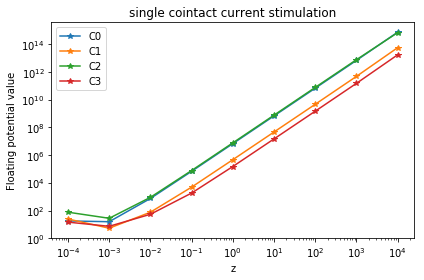

In [10]:
for i in range(4):
    plt.loglog(zs, [abs(fp) for fp in monitor_efem['U'+str(i)]],
               label='C'+str(i), marker='*')
    plt.legend()
plt.xlabel('z')
plt.ylabel('Floating potential value')
plt.title('single cointact current stimulation')
plt.tight_layout()
plt.savefig('results/FP_varations_multicontact.png', dpi=300,
           bbox_inches='tight')